In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=25

In [3]:
#loading images from dataset folder
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    seed = 123,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
#names of folders
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#68 batches of 32
len(dataset)

68

In [6]:
#showing shape and labels of the 3 diff classes
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [7]:
#image as array
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[163., 161., 172.],
        [129., 127., 138.],
        [108., 106., 117.],
        ...,
        [163., 161., 175.],
        [158., 156., 170.],
        [153., 151., 165.]],

       [[149., 147., 158.],
        [ 98.,  96., 107.],
        [144., 142., 153.],
        ...,
        [159., 157., 171.],
        [165., 163., 177.],
        [168., 166., 180.]],

       [[100.,  98., 109.],
        [117., 115., 126.],
        [188., 186., 199.],
        ...,
        [163., 161., 175.],
        [164., 162., 176.],
        [164., 162., 176.]],

       ...,

       [[142., 138., 153.],
        [120., 116., 131.],
        [136., 132., 147.],
        ...,
        [180., 178., 191.],
        [178., 176., 189.],
        [189., 187., 200.]],

       [[118., 114., 129.],
        [102.,  98., 113.],
        [157., 153., 168.],
        ...,
        [177., 175., 188.],
        [172., 170., 183.],
       

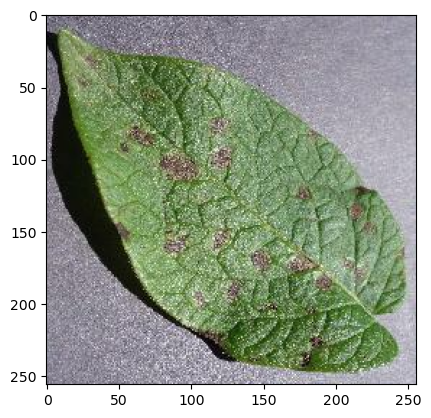

In [8]:
#visualize dataset
plt.imshow(image_batch[0].numpy().astype("uint8"))

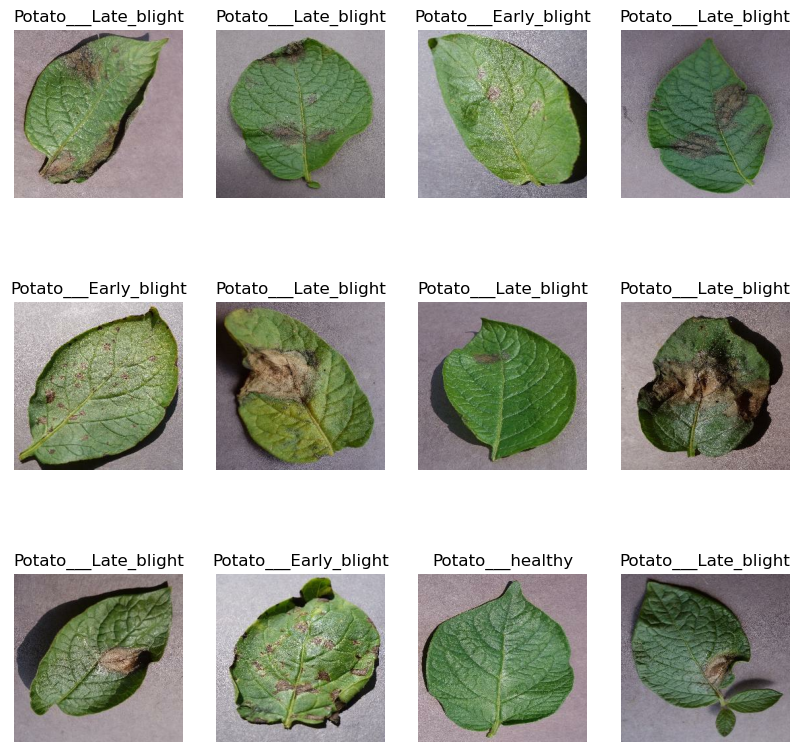

In [9]:
#display a few images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
#80% - train
#20% => 10% validation 10% test
len(dataset)
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
#train dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
#test dataset
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
#validation ds
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
#test ds
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
#function to split data
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
#optimize performance using cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#cleaning by scale and size image to standard
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
#flipping and rotating images to produce duplicates to train model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
#building model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #conv layer
    layers.MaxPooling2D((2, 2)), #pooling layer
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), #flatten after final pooling
    layers.Dense(64, activation='relu'), #hidden layer
    layers.Dense(n_classes, activation='softmax'), #3 neurons same as CHANNELS
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
#compile model using adam opt

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 [==============================] - 261s 4s/step - loss: 0.9071 - accuracy: 0.5133 - val_loss: 0.8530 - val_accuracy: 0.5521
Epoch 2/25
54/54 [==============================] - 177s 3s/step - loss: 0.6337 - accuracy: 0.7297 - val_loss: 0.9356 - val_accuracy: 0.6823
Epoch 3/25
54/54 [==============================] - 178s 3s/step - loss: 0.3847 - accuracy: 0.8466 - val_loss: 0.5165 - val_accuracy: 0.8177
Epoch 4/25
54/54 [==============================] - 178s 3s/step - loss: 0.2892 - accuracy: 0.8895 - val_loss: 0.5125 - val_accuracy: 0.7865
Epoch 5/25
54/54 [==============================] - 177s 3s/step - loss: 0.2337 - accuracy: 0.9034 - val_loss: 0.1940 - val_accuracy: 0.9323
Epoch 6/25
54/54 [==============================] - 177s 3s/step - loss: 0.2230 - accuracy: 0.9080 - val_loss: 0.1508 - val_accuracy: 0.9479
Epoch 7/25
54/54 [==============================] - 178s 3s/step - loss: 0.2120 - accuracy: 0.9109 - val_loss: 0.1816 - val_accuracy: 0.9271
Epoch 8/25
54

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 47s 747ms/step - loss: 0.1901 - accuracy: 0.9219


In [28]:
#shows loss and accuracy
scores

[0.19013017416000366, 0.921875]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:

len(history.history['loss'])

25

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9070632457733154,
 0.6337378621101379,
 0.3846850097179413,
 0.28920778632164,
 0.2337265908718109]

In [35]:
history.history['accuracy'][:5]

[0.5133101940155029,
 0.7297453880310059,
 0.8466435074806213,
 0.8894675970077515,
 0.9033564925193787]

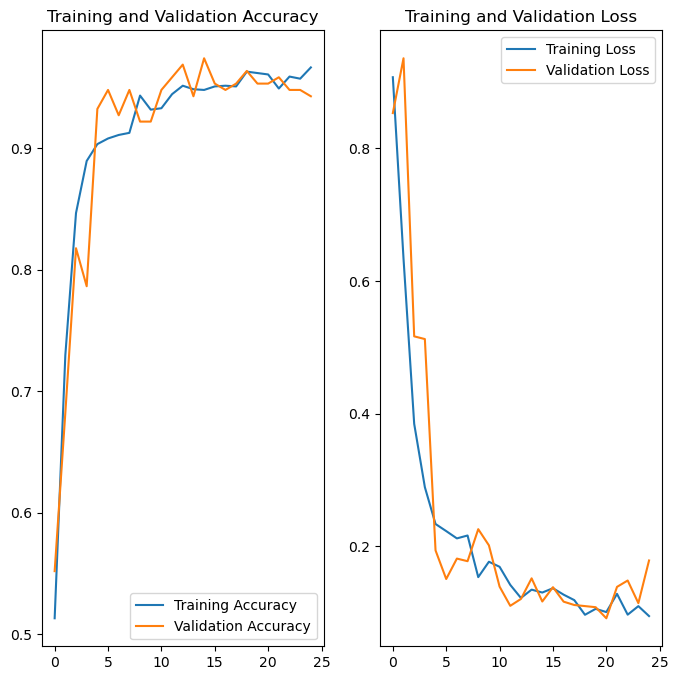

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


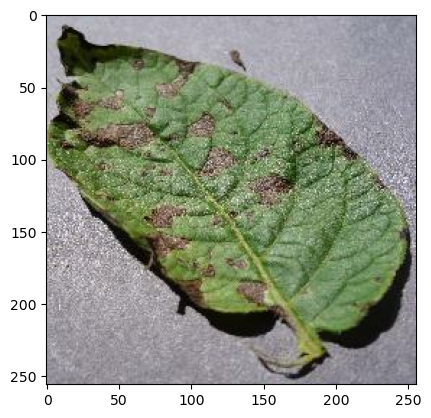

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 58ms/step


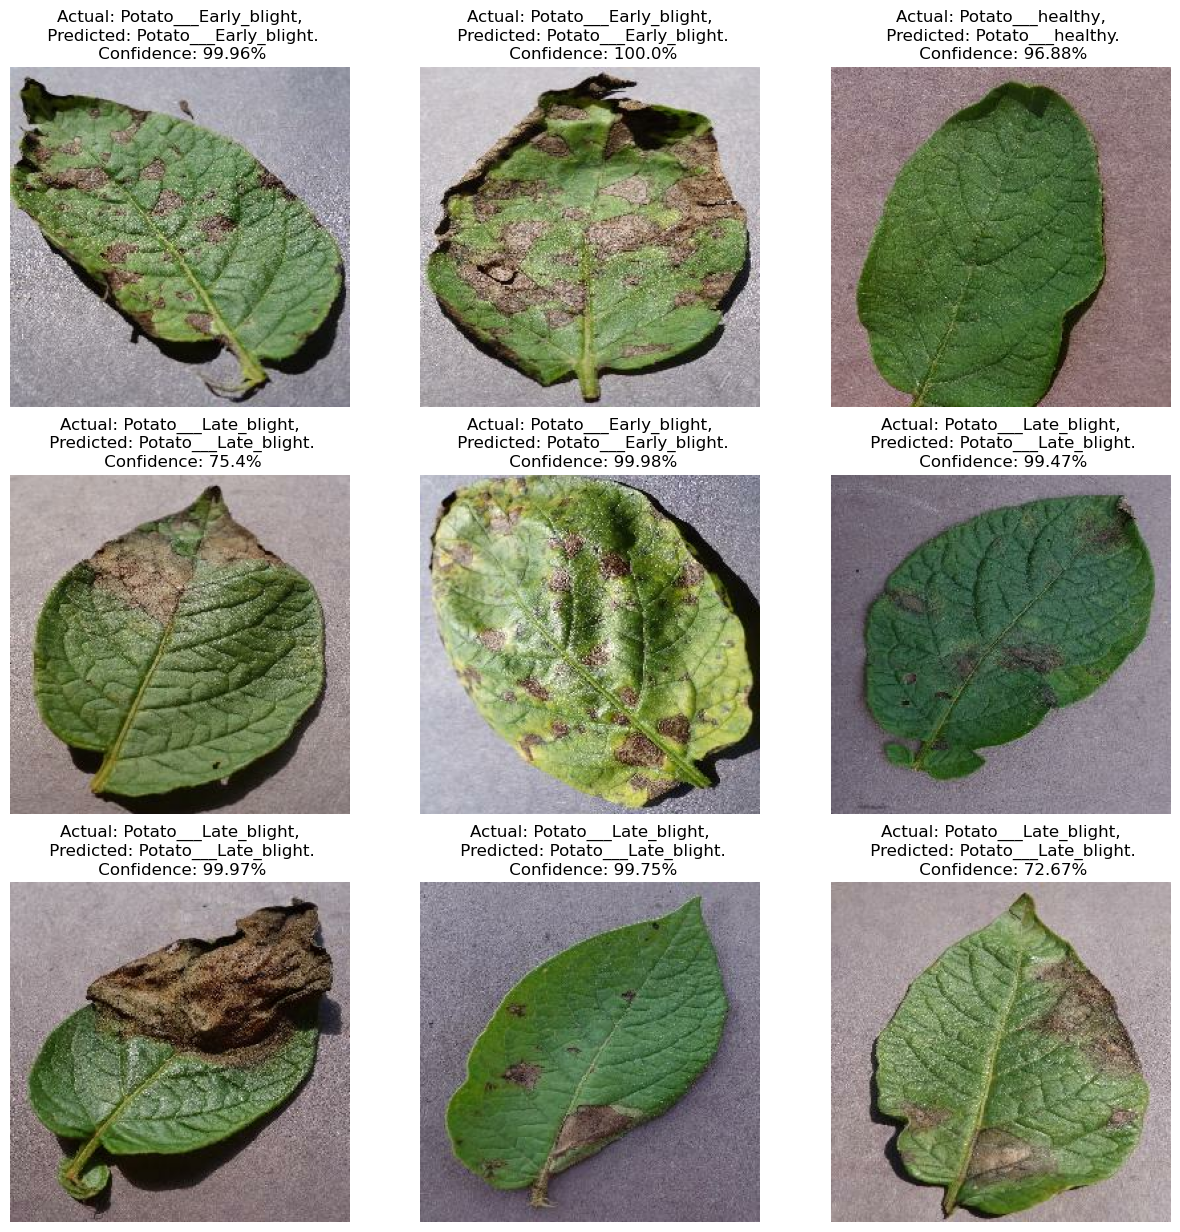

In [42]:
#function for prediction, returns results and confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [40]:
model.save("../potatoes.h5")

C:\Users\balm\anaconda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
